# Algoritmo de Busqueda de Prendas Similares

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
import warnings
from crop import crop_cv_pct, cluster_color


import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.models import load_model
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

In [2]:
DB_Prendas_Features = pd.read_pickle('./DB/DB_prendas_features.pkl') #se carga la base de datos de prendas y features

In [3]:
DB_Prendas_Features.tail()

,path,feature,color,categoria_text,categoria_num
16797,Input\MUJER-VESTIDO\9625.jpg,"[[3.3919806, 0.0, 3.2406058, 0.0, 0.0, 2.57588...","[[0.6316847515705315, 0.5951113649343229, 0.56...",MUJER-VESTIDO,11
16798,Input\MUJER-VESTIDO\9626.jpg,"[[3.3847044, 0.0, 3.2491517, 0.0, 0.0, 2.93929...","[[0.7809156047539367, 0.7038228858282922, 0.71...",MUJER-VESTIDO,11
16799,Input\MUJER-VESTIDO\9627.jpg,"[[2.9895465, 0.0, 2.75493, 0.0, 0.0, 1.8543208...","[[0.8690989096008321, 0.8566959212784986, 0.81...",MUJER-VESTIDO,11
16800,Input\MUJER-VESTIDO\9865.jpg,"[[3.960384, 0.0, 3.5620036, 0.0, 0.0, 2.727210...","[[0.6429415528207446, 0.6089571337172108, 0.56...",MUJER-VESTIDO,11
16801,Input\MUJER-VESTIDO\9905.jpg,"[[3.7325702, 0.0, 4.0760083, 0.0, 0.0, 2.12441...","[[0.041660382101558646, 0.029273504273503947, ...",MUJER-VESTIDO,11


In [4]:
DB_Prendas_Features.head()

,path,feature,color,categoria_text,categoria_num
0,Input\HOMBRE-BUSO\10270.jpg,"[[0.0, 1.4480228, 0.0, 0.0, 0.018729024, 0.0, ...","[[0.09663999251251981, 0.09233001076325714, 0....",HOMBRE-BUSO,5
1,Input\HOMBRE-BUSO\10271.jpg,"[[0.0, 1.3410525, 0.0, 0.0, 0.09569714, 0.0, 0...","[[0.9849683952528372, 0.9833075335397333, 0.98...",HOMBRE-BUSO,5
2,Input\HOMBRE-BUSO\10272.jpg,"[[0.0, 1.5886359, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.02617081920487495, 0.025984077841661887, 0...",HOMBRE-BUSO,5
3,Input\HOMBRE-BUSO\10273.jpg,"[[0.4330516, 1.1938989, 0.0, 0.0, 0.0, 0.0, 0....","[[0.051571250955297625, 0.05334154604250103, 0...",HOMBRE-BUSO,5
4,Input\HOMBRE-BUSO\10510.jpg,"[[0.035746604, 1.0029361, 0.9901881, 0.0, 0.0,...","[[0.11913157563667087, 0.11574558329289567, 0....",HOMBRE-BUSO,5


In [5]:
DB_Prendas_Features["categoria_num"].describe()

count    16802.000000
mean         9.490239
std          4.497292
min          0.000000
25%          7.000000
50%          8.000000
75%         14.000000
max         18.000000
Name: categoria_num, dtype: float64

## Se carga y se obtienen los features de la prenda a analizar

In [6]:
path_input = os.path.join("./Fotos_Clasificar_Comparar")

In [7]:
base_model = tf.keras.models.load_model('saved_model/modelo_04_100_epochs_vgg16_modificado_2_sin_transfer_data_ampl.h5')
x = base_model.get_layer('dropout_2').output
feature_model = Model(inputs=base_model.input, outputs=x) #conexion del nuevo modelo

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
IMG_S = 128


def feature_ext(image_new):
    try:        
        print(image_new)
        imagex = cv2.imread(os.path.join(path_input,image_new), cv2.IMREAD_ANYCOLOR)
        print("se leyó la imagen con resolución: {}".format(imagex.shape))
        imagex = cv2.resize(imagex, (IMG_S, IMG_S))
        print("La imagen se reajustó al tamaño: ".format(imagex.shape))
        imagex = cv2.cvtColor(imagex, cv2.COLOR_BGR2RGB)
        print("La imagen se ajustó a los colores RGB ")
        imagex = np.array(imagex)/255.
        print("La imagen se escaló en 255")
        imagex = np.expand_dims(imagex, axis=0)
        print("la imagen se expandio en una componente para la entrada al feature extractor")
        feature_ropa_test = feature_model.predict(imagex)
        print("se extrajeron las características de la imagen con un vector de tamaño: {}".format(feature_ropa_test.shape))
        return feature_ropa_test
    except:
        print("--------------------------------------")
        print("se presentó un problema con la imagen 1")
        print("--------------------------------------")

        
def color_ext(image_new):
    try:
        print(image_new)
        imagex = cv2.imread(os.path.join(path_input,image_new), cv2.IMREAD_ANYCOLOR)
        print("se leyó la imagen con resolución: {}".format(imagex.shape))
        print("La imagen se reajustó al tamaño: ".format(imagex.shape))
        imagex = cv2.cvtColor(imagex, cv2.COLOR_BGR2RGB)
        print("La imagen se ajustó a los colores RGB ")
        imagex = np.array(imagex)/255.
        print("La imagen se escaló en 255")
        crop = crop_cv_pct(imagex, pct=0.33)
        print("A la imagen se le hizo el crop")
        color_ = cluster_color(crop)
        color_ =  np.expand_dims(color_, axis=0)
        print("El color principal de la imagen es: {}".format(color_))
        return color_
    except:
        print("--------------------------------------")
        print("se presentó un problema con la imagen 2")
        print("--------------------------------------")        
        
def clasificar(image_new):
    try:
        print(image_new)
        imagex = cv2.imread(os.path.join(path_input,image_new), cv2.IMREAD_ANYCOLOR)
        print("se leyó la imagen con resolución: {}".format(imagex.shape))
        imagex = cv2.resize(imagex, (IMG_S, IMG_S))
        print("La imagen se reajustó al tamaño: ".format(imagex.shape))
        imagex = cv2.cvtColor(imagex, cv2.COLOR_BGR2RGB)
        print("La imagen se ajustó a los colores RGB ")
        imagex = np.array(imagex)/255.
        print("La imagen se escaló en 255")
        imagex = np.expand_dims(imagex, axis=0)
        print("la imagen se expandio en una componente para la entrada al feature extractor")
        tipo_ropa = base_model.predict(imagex)
        tipo_ropa = np.argmax(tipo_ropa, axis = 1)
        print ("se predijo el tipo de ropa: {}".format(tipo_ropa))
        return tipo_ropa
    except:
        print("--------------------------------------")
        print("se presentó un problema con la imagen 3")
        print("--------------------------------------")
        
   

# SELECCIONAR LA PRENDA PARA LA BUSQUEDA

In [252]:
try:
    image_new = str(input("Por favor ingrese el nombre de la imagen:  "))
    feature_ropa =  feature_ext(image_new)
    feature_color = color_ext(image_new)
    tipo = clasificar(image_new)
except:
    print ("error cargando la imagen")

Por favor ingrese el nombre de la imagen:   vestido_mujer_01.jpeg


vestido_mujer_01.jpeg
se leyó la imagen con resolución: (360, 480, 3)
La imagen se reajustó al tamaño: 
La imagen se ajustó a los colores RGB 
La imagen se escaló en 255
la imagen se expandio en una componente para la entrada al feature extractor
se extrajeron las características de la imagen con un vector de tamaño: (1, 1024)
vestido_mujer_01.jpeg
se leyó la imagen con resolución: (360, 480, 3)
La imagen se reajustó al tamaño: 
La imagen se ajustó a los colores RGB 
La imagen se escaló en 255
A la imagen se le hizo el crop
El color principal de la imagen es: [[0.54141452 0.06094382 0.14049737]]
vestido_mujer_01.jpeg
se leyó la imagen con resolución: (360, 480, 3)
La imagen se reajustó al tamaño: 
La imagen se ajustó a los colores RGB 
La imagen se escaló en 255
la imagen se expandio en una componente para la entrada al feature extractor
se predijo el tipo de ropa: [11]


## Se mide la distancia respecto las prenda de la base de datos

In [253]:
#se filtra la base de datos y se dejan las prendas de la categoría predicha
DB_Filtered = DB_Prendas_Features[DB_Prendas_Features['categoria_num']==tipo[0]]

In [254]:
features_list = list(DB_Filtered['feature'])

In [255]:
#import scipy
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import canberra
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import cosine

In [256]:
distancia = list()
for i in range(len(features_list)):
    tmp1 = cosine(features_list[i], feature_ropa)
    distancia.append(tmp1)
    

In [257]:
DB_Filtered["distancia"] = distancia

In [258]:
distancia_c = list()
features_list_c = list(DB_Filtered['color'])
for i in range(len(features_list_c)):
    #tmp = features_list[i] - feature_ropa
    #sum_squared = np.dot(tmp, tmp.T)
    euc_d = euclidean_distances(features_list_c[i],feature_color)
    distancia_c.append(euc_d)

In [259]:
DB_Filtered["distancia_c"] = distancia_c

In [260]:
DB_Filtered.head()

,path,feature,color,categoria_text,categoria_num,distancia,distancia_c
15685,Input\MUJER-VESTIDO\10042.jpg,"[[3.870875, 0.0, 2.983428, 0.0, 0.0, 3.040108,...","[[0.8004153050108933, 0.6988357843137256, 0.61...",MUJER-VESTIDO,11,0.141861,[[0.8376899020755206]]
15686,Input\MUJER-VESTIDO\10150.jpg,"[[4.244176, 0.0, 4.4749856, 0.0, 0.0, 1.726899...","[[0.8834067829086021, 0.8826275787187845, 0.88...",MUJER-VESTIDO,11,0.181558,[[1.1595145229161448]]
15687,Input\MUJER-VESTIDO\10151.jpg,"[[5.7554507, 0.0, 5.2187405, 0.0, 0.0, 3.98710...","[[0.9122086570477256, 0.9172586015538289, 0.95...",MUJER-VESTIDO,11,0.153590,[[1.2355917123178108]]
15688,Input\MUJER-VESTIDO\10152.jpg,"[[3.763772, 0.0, 4.7580295, 0.0, 0.0, 2.437856...","[[0.8997419320509767, 0.8982254502886602, 0.90...",MUJER-VESTIDO,11,0.154209,[[1.1874458217571233]]
15689,Input\MUJER-VESTIDO\10154.jpg,"[[1.9349233, 0.19408888, 1.3004115, 0.0, 0.0, ...","[[0.04846783893693507, 0.030788323118922878, 0...",MUJER-VESTIDO,11,0.180652,[[0.5075252971098997]]


In [261]:
DB_Filtered["distancia"]= DB_Filtered["distancia"].astype(float)
DB_Filtered["distancia_c"]= DB_Filtered["distancia_c"].astype(float)

# seleccionar la ponderación que se le dara al feature color vs deep featute - numero entre 0 y 1

In [262]:
#seleccionar la ponderación que se le dara al feature color vs deep featute - numero entre 0 y 1
pond_color = 0.9

In [263]:
DB_Filtered["Combined_Feature"] = DB_Filtered["distancia"]*(1-pond_color) + DB_Filtered["distancia_c"]*(pond_color)

In [264]:
#DB_Filtered.head()

In [265]:
DB_Filtered.sort_values(['Combined_Feature'],ascending=[True],inplace=True)

In [266]:
DB_Filtered.head(10)

,path,feature,color,categoria_text,categoria_num,distancia,distancia_c,Combined_Feature
16374,Input\MUJER-VESTIDO\3322.jpg,"[[3.7447152, 0.0, 3.6714478, 0.0, 0.0, 2.56372...","[[0.5620663650075414, 0.09404761904761905, 0.1...",MUJER-VESTIDO,11,0.155307,0.041486,0.052868
15806,Input\MUJER-VESTIDO\13584.jpg,"[[3.29537, 0.0, 3.4538784, 0.0, 0.0, 2.8712337...","[[0.565994176908608, 0.08988688773801236, 0.11...",MUJER-VESTIDO,11,0.141892,0.043695,0.053514
15766,Input\MUJER-VESTIDO\12656.jpg,"[[4.4473214, 0.0, 4.6294303, 0.0, 0.0, 3.00283...","[[0.571748699479792, 0.0950164681257118, 0.155...",MUJER-VESTIDO,11,0.153292,0.048000,0.058530
15967,Input\MUJER-VESTIDO\17500.jpg,"[[3.7642047, 0.0, 3.8074832, 0.0, 0.0, 2.17637...","[[0.5975230928779868, 0.05051009333622839, 0.1...",MUJER-VESTIDO,11,0.136502,0.057086,0.065028
16507,Input\MUJER-VESTIDO\38298.jpg,"[[3.7575839, 0.0, 3.69106, 0.0, 0.0, 2.1058128...","[[0.5749656443774088, 0.07181833417127557, 0.0...",MUJER-VESTIDO,11,0.150754,0.056968,0.066347
15843,Input\MUJER-VESTIDO\14293.jpg,"[[3.5970461, 0.26347482, 3.9985719, 0.0, 0.0, ...","[[0.479830327546491, 0.08138097645935186, 0.14...",MUJER-VESTIDO,11,0.161033,0.064910,0.074523
16093,Input\MUJER-VESTIDO\22430.jpg,"[[3.2529187, 0.0, 3.3573847, 0.0, 0.0, 2.71247...","[[0.5835519342872286, 0.12849761526232104, 0.1...",MUJER-VESTIDO,11,0.148387,0.088896,0.094845
15964,Input\MUJER-VESTIDO\17497.jpg,"[[4.080925, 0.113076776, 4.3616977, 0.0, 0.0, ...","[[0.6010342084327759, 0.04042304272543934, 0.0...",MUJER-VESTIDO,11,0.137610,0.090594,0.095296
16551,Input\MUJER-VESTIDO\40405.jpg,"[[4.297419, 0.0, 4.3325105, 0.0, 0.0, 2.494066...","[[0.6114611534990565, 0.08524079087702065, 0.0...",MUJER-VESTIDO,11,0.153374,0.088981,0.095421
16433,Input\MUJER-VESTIDO\35710.jpg,"[[3.1793644, 0.0, 3.1111279, 0.0, 0.0, 2.00193...","[[0.4725424397947098, 0.06753520200026318, 0.0...",MUJER-VESTIDO,11,0.159836,0.091043,0.097922


## Seleccionar N prendas más similares

Cuantas prendas similares quiere hallar?

In [267]:
num_prendas = 5
DB_Filtered = DB_Filtered.sort_values(by=['Combined_Feature'])
prendas = DB_Filtered.iloc[0:num_prendas,0]

In [268]:
prendas = list(prendas)

## Prenda de Búsqueda

prenda de búsqueda


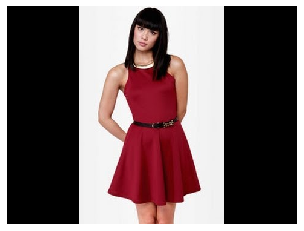

In [269]:
print ("prenda de búsqueda")
plt.axis('off')
img =  cv2.imread(os.path.join(path_input,image_new), cv2.IMREAD_ANYCOLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Prendas Similares

La prenda en el ranking 1 de milaridad es: 


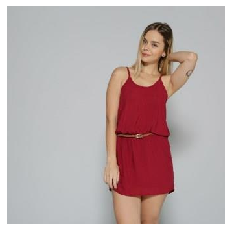

In [270]:
print("La prenda en el ranking 1 de milaridad es: ")
plt.axis('off')
img =  cv2.imread(os.path.join(prendas[0]), cv2.IMREAD_ANYCOLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
    

La prenda en el ranking 2 de milaridad es: 


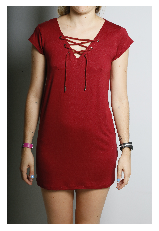

In [271]:
print("La prenda en el ranking 2 de milaridad es: ")
plt.axis('off')
img =  cv2.imread(os.path.join(prendas[1]), cv2.IMREAD_ANYCOLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
    

La prenda en el ranking 3 de milaridad es: 


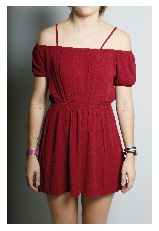

In [272]:
print("La prenda en el ranking 3 de milaridad es: ")
plt.axis('off')
img =  cv2.imread(os.path.join(prendas[2]), cv2.IMREAD_ANYCOLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

La prenda en el ranking 4 de milaridad es: 


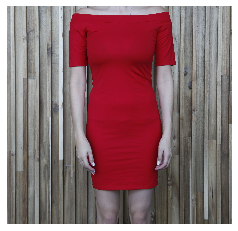

In [273]:
print("La prenda en el ranking 4 de milaridad es: ")
plt.axis('off')
img =  cv2.imread(os.path.join(prendas[3]), cv2.IMREAD_ANYCOLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

La prenda en el ranking 5 de milaridad es: 


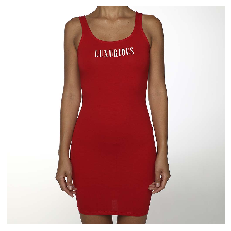

In [274]:
print("La prenda en el ranking 5 de milaridad es: ")
plt.axis('off')
img =  cv2.imread(os.path.join(prendas[4]), cv2.IMREAD_ANYCOLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)